# Chapter 02 — Raw Reads and Downsampling

## Objective

In this chapter, we load all molecule info files from CellRanger (or equivalent for your protocol), and use that to generate plots based on the raw reads from the experiment. Later, we will perform downsampling in order to measure UMI/gene capture at different sequencing depths. This will also allow us to make "apples to apples" comparisons between protocols such that sequencing depth does not introduce technical bias in any biological analyses.

This includes:

- Reading in the `molecule_info.h5` files
- Generating plots based on the total raw reads for all droplets by protocol across tissues
- Filtering the raw `molecule_info.h5` files to only CellRanger called cells
- Map Ensembl IDs to gene symbols
- Downsampling the UMIs to different total reads
- Generating downsampling curves to quantify UMI/gene capture at different levels

## Data Inputs and Outputs
- Molecule Info files will be under their respective sample directories under the "read only" parent directory
- AnnDatas will come from "adatas/adatas_X_filtered_cells_raw"
- Updated AnnDatas will be outputed to "adatas/adatas_X_filtered_cells_raw_with_downsampled_layer"
- Figures will be outputted to "figures/chapter_02_raw_reads_and_downsampling"



##### Run Autoreload (Automically Reloads Edited Module Files)

In [1]:
%load_ext autoreload
%autoreload 2

#### Imports

In [2]:
import gzip
import os
from typing import Dict
from collections import defaultdict

import h5py
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import polars as pl
import scanpy as sc
from scipy import sparse

import utils
import utils.config as config

### File Paths

In [3]:
# File and directory paths
figures_output_dir = config.FIGURES_DIR / "chapter_02_raw_reads_and_downsampling"
input_adata_dir = config.ADATA_DIR / "adatas_X_filtered_cells_raw"
output_adata_dir = config.ADATA_DIR / "adatas_X_filtered_cells_raw_with_downsampled_layer"

# Make sure output directories exist
os.makedirs(figures_output_dir, exist_ok=True)
os.makedirs(output_adata_dir, exist_ok=True)

### Read in Molecule Info files

#### Functions

- read_molecule_info - Reads in molecule_info.h5 files from CellRanger

In [4]:
def read_molecule_info(file_path: str) -> pl.DataFrame:
    """
    Load molecule_info.h5 and return a Polars DataFrame with cell barcodes, UMIs, read counts, and gene IDs.

    Parameters:
        file_path (str): Path to the molecule_info.h5 file.

    Returns:
        pl.DataFrame: DataFrame with columns ['cell', 'umi', 'reads', 'gene_id'].
    """
    with h5py.File(file_path, "r") as f:
        barcode_idx = f["barcode_idx"][:]
        umi = f["umi"][:]
        gene_idx = f["feature_idx"][:]
        reads = f["count"][:]
        barcodes = np.array([b.decode("utf-8") for b in f["barcodes"][:]])
        gene_ids = np.array([g.decode("utf-8") for g in f["features"]["id"][:]])

    # Map indices to actual barcode and gene strings
    return pl.DataFrame(
        {
            "cell": barcodes[barcode_idx],
            "umi": umi,
            "reads": reads,
            "gene_id": gene_ids[gene_idx],
        }
    )

In [5]:
# Load AnnData objects
molecule_info_dict = {}

sample_metadata = config.SAMPLES_METADATA
sample_identifier = config.SAMPLE_IDENTIFIER
input_data_dir = config.DATA_DIR / "read_only"
molecule_info_file_name = "molecule_info.h5"

for key, sample_info in sample_metadata.items():
    tissue = sample_info["tissue"]
    protocol = sample_info["protocol"]

    folder = f"{sample_identifier}_{key}"

    file_path = os.path.join(
        input_data_dir,
        folder,
        f"analyses/CellRangerGex-9.0.0-{folder}/outputs",
        molecule_info_file_name,
    )

    molecule_info = read_molecule_info(file_path)
    molecule_info_dict[key] = molecule_info
    print(f"{key}: {molecule_info}")

SF_N: shape: (43_437_252, 4)
┌──────────────────┬──────────┬───────┬─────────────────┐
│ cell             ┆ umi      ┆ reads ┆ gene_id         │
│ ---              ┆ ---      ┆ ---   ┆ ---             │
│ str              ┆ u32      ┆ u32   ┆ str             │
╞══════════════════╪══════════╪═══════╪═════════════════╡
│ AAACCCAAGAAACTAC ┆ 8610835  ┆ 4     ┆ ENSG00000120694 │
│ AAACCCAAGAAATGGG ┆ 3363451  ┆ 1     ┆ ENSG00000162601 │
│ AAACCCAAGAAATTCG ┆ 4789362  ┆ 8     ┆ ENSG00000081237 │
│ AAACCCAAGAAATTCG ┆ 9327751  ┆ 4     ┆ ENSG00000185024 │
│ AAACCCAAGAAATTGC ┆ 12148460 ┆ 7     ┆ ENSG00000170919 │
│ …                ┆ …        ┆ …     ┆ …               │
│ TTTGTTGTCTTTCTAG ┆ 14289167 ┆ 3     ┆ ENSG00000140563 │
│ TTTGTTGTCTTTGATC ┆ 14983255 ┆ 3     ┆ ENSG00000072415 │
│ TTTGTTGTCTTTGCGC ┆ 2849353  ┆ 1     ┆ ENSG00000158711 │
│ TTTGTTGTCTTTGCGC ┆ 10510539 ┆ 1     ┆ ENSG00000154229 │
│ TTTGTTGTCTTTGGAG ┆ 10439921 ┆ 6     ┆ ENSG00000102974 │
└──────────────────┴──────────┴───────┴────

### Plotting

Throughout most of these analyses we will be using the following three functions from ./utils.

These are: <br>

- plot_scalar_metric — Computes and plots scalar summary statistics (e.g., total reads, mean UMIs) for each sample using a user-provided metric function. Results are grouped by tissue and protocol, and displayed as bar plots with optional annotations and protocol-specific color palettes. <br>

- plot_adata_metric_histogram — Plots histograms of per-cell or per-gene metrics (e.g., n_genes_by_counts, pct_counts_mitochondrial) for each sample, grouped by protocol. Supports log-transformed axes, proportion-based bin heights, and filtering to nonzero values. <br>

- plot_adata_metric_violin — Generates violin plots of distributions for any .obs or .var field in each AnnData object. This is useful for visualizing differences in gene or cell-level statistics (e.g., total_counts, n_genes_by_counts) across protocols or tissues.

#### Plotting Configs

In [6]:
# Load protocol color palette and tissue order
protocol_color_palette = config.PROTOCOL_COLOR_PALETTE
tissue_order = config.TISSUE_ORDER

#### Generate Plots

We'll be creating the following plots:

- Total Raw Reads (all droplets)
- Average Raw Reads (all droplets)

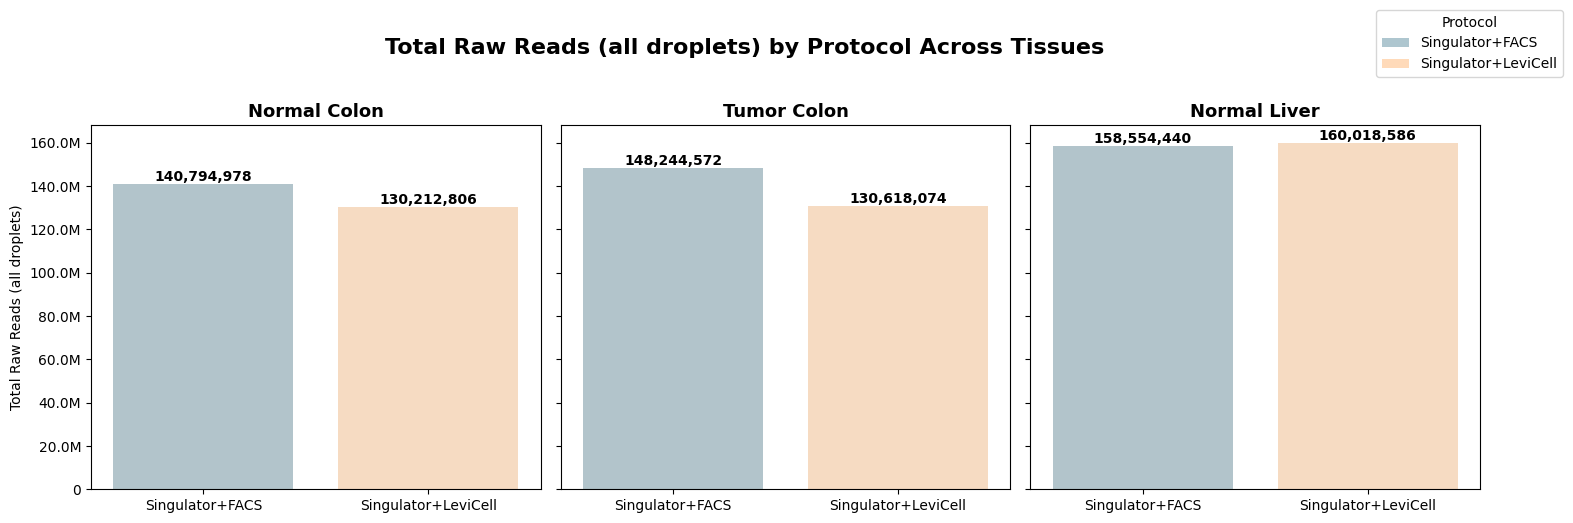

In [7]:
# Plot the total reads per sample for all droplets
fig = utils.plot_scalar_metric(
    data_dict=molecule_info_dict,
    metadata=sample_metadata,
    metric_func=lambda df: df["reads"].sum(),  # Total reads per sample
    metric_label="Total Raw Reads (all droplets)",
    protocol_color_palette=protocol_color_palette,
    tissue_order=tissue_order,
)

# Save the figure
fig.savefig(
    os.path.join(figures_output_dir, "total_raw_reads_all_droplets.png"),
    bbox_inches="tight",
)

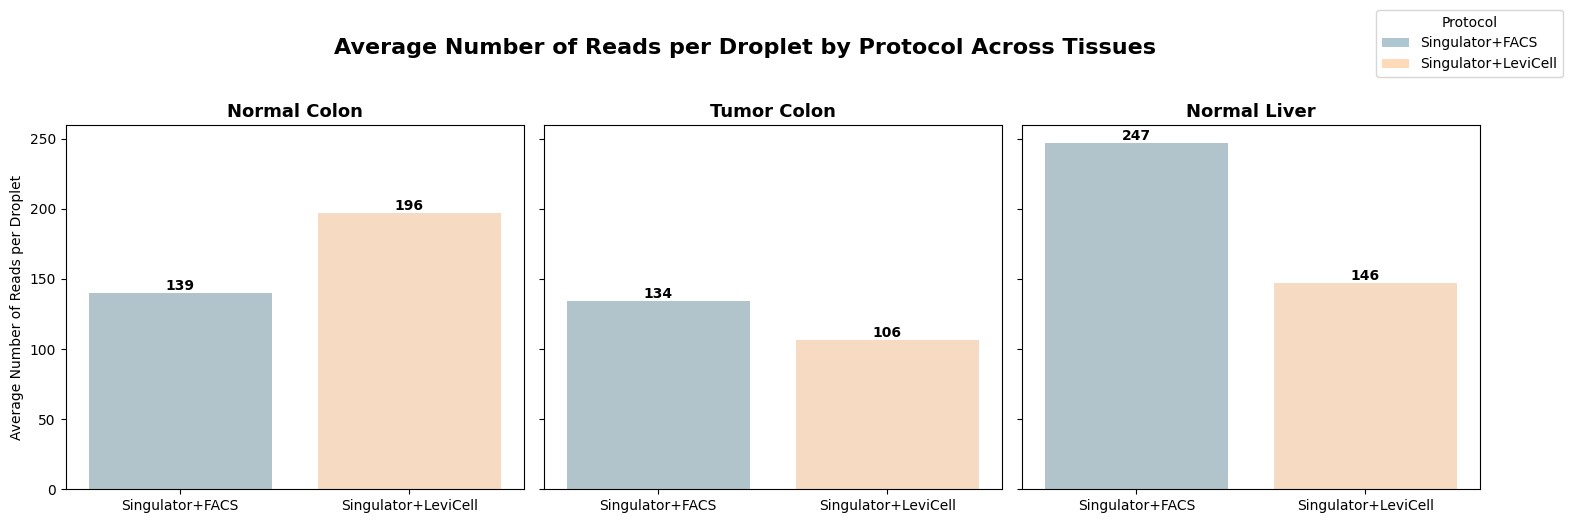

In [8]:
# Plot the total reads per sample for all droplets normalized by number of droplets
fig = utils.plot_scalar_metric(
    data_dict=molecule_info_dict,
    metadata=sample_metadata,
    metric_func=lambda df: df["reads"].sum()
    / df["cell"].n_unique(),  # Total reads per sample divided by number of unique cells
    metric_label="Average Number of Reads per Droplet",
    protocol_color_palette=protocol_color_palette,
    tissue_order=tissue_order,
)

# Save the figure
fig.savefig(
    os.path.join(figures_output_dir, "average_reads_per_droplet.png"),
    bbox_inches="tight",
)

### Read in Filtered Barcodes

In [9]:
# Load Molecule Info as Polars DataFrames
filtered_barcode_dict = {}
cell_ranger_filtered_barcodes_file_name = "filtered_feature_bc_matrix/barcodes.tsv.gz"

for key, sample_info in sample_metadata.items():
    tissue = sample_info["tissue"]
    protocol = sample_info["protocol"]

    folder = f"{sample_identifier}_{key}"

    file_path = os.path.join(
        input_data_dir,
        folder,
        f"analyses/CellRangerGex-9.0.0-{folder}/outputs",
        cell_ranger_filtered_barcodes_file_name,
    )

    with gzip.open(file_path, "rt", encoding="utf-8") as f:
        filtered_barcodes = f.read().splitlines()

    filtered_barcode_dict[key] = filtered_barcodes
    print(f"{key}: {filtered_barcodes[:10]}")

SF_N: ['AAACCCAAGAGAGCGG-1', 'AAACCCAAGTAGTCAA-1', 'AAACCCACAAACACGG-1', 'AAACCCACAGAACTCT-1', 'AAACCCACAGCTGGTC-1', 'AAACCCACATCGATAC-1', 'AAACCCACATCGCCTT-1', 'AAACCCAGTATCTCTT-1', 'AAACCCAGTCCTGTCT-1', 'AAACCCATCGGATAAA-1']
SL_N: ['AAACCCACAAACACCT-1', 'AAACCCACACGAAGAC-1', 'AAACCCACAGCGTGCT-1', 'AAACCCAGTGTTTGCA-1', 'AAACCCATCAGGACGA-1', 'AAACGAAAGAGAATCT-1', 'AAACGAAAGTGCCCGT-1', 'AAACGAACAAGCCATT-1', 'AAACGAACATCTCCCA-1', 'AAACGAACATTCTTCA-1']
SF_T: ['AAACCCAAGTAGGTTA-1', 'AAACCCACAATTAGGA-1', 'AAACCCAGTCCAAATC-1', 'AAACCCATCACCATGA-1', 'AAACCCATCCTACGAA-1', 'AAACGAAAGGCACGAT-1', 'AAACGAAAGTACCGGA-1', 'AAACGAAAGTATGCAA-1', 'AAACGAACAATTTCCT-1', 'AAACGAATCGGATAAA-1']
SL_T: ['AAACCCAAGTAGGTTA-1', 'AAACCCACAAGGGTCA-1', 'AAACCCACACGTGAGA-1', 'AAACCCACACTGCTTC-1', 'AAACCCACAGGAACCA-1', 'AAACCCACATCCTGTC-1', 'AAACCCAGTTAAGAAC-1', 'AAACCCATCAAGCCGC-1', 'AAACCCATCCGGTAAT-1', 'AAACCCATCTAAGAAG-1']
SF_LN: ['AAACCCAAGACATAGT-1', 'AAACCCAAGAGTTCGG-1', 'AAACCCACAACAGTGG-1', 'AAACCCACATTGAAAG-

### Filter Molecule Infos

#### Functions

- filter_all_molecule_infos - takes in a dict of molecule infos and fileters to a set of barcodes<br>
  
- map_ensembl_id_to_gene_symbol - takes in molecule info Polars dataframe and maps any Ensembl IDs to their corresponding gene symbol

In [10]:
def filter_all_molecule_infos(
    molecule_info_dict: Dict[str, pl.DataFrame], filtered_barcode_dict: Dict[str, list[str]]
) -> Dict[str, pl.DataFrame]:
    """
    Filters a dictionary of molecule_info DataFrames using corresponding filtered barcodes.

    Handles mismatched '-1' suffixes between barcode sources.

    Args:
        molecule_info_dict (Dict[str, pl.DataFrame]): Dictionary of Polars DataFrames keyed by sample ID.
        filtered_barcode_dict (Dict[str, list[str]]): Dictionary of barcode lists keyed by sample ID.

    Returns:
        Dict[str, pl.DataFrame]: Filtered molecule_info DataFrames.
    """
    filtered_molecule_info_dict = {}

    for key, df in molecule_info_dict.items():
        barcodes = filtered_barcode_dict[key]

        # Harmonize '-1' suffixes
        if barcodes and barcodes[0].endswith("-1") and not df["cell"][0].endswith("-1"):
            barcodes = [b.rstrip("-1") for b in barcodes]
        elif (
            df["cell"][0].endswith("-1") and barcodes and not barcodes[0].endswith("-1")
        ):
            df = df.with_columns(pl.col("cell").str.rstrip("-1"))

        filtered_molecule_info_dict[key] = df.filter(pl.col("cell").is_in(barcodes))

    return filtered_molecule_info_dict

In [11]:
# Convert ENSEMBL IDs to gene symbols in the filtered molecule infos
def map_ensembl_id_to_gene_symbol(molecule_info, ensembl_to_symbol):
    """
    Maps ENSEMBL gene IDs to gene symbols in the molecule_info DataFrame.

    Args:
        molecule_info (pl.DataFrame): Polars DataFrame with a 'gene_id' column containing ENSEMBL IDs.
        ensembl_to_symbol (Dict[str, str]): Dictionary of mappings from Ensembl ID to gene symbol
    Returns:
        pl.DataFrame: Updated DataFrame with an additional 'gene_symbol' column.
    """
    return molecule_info.with_columns(
        [
            pl.col("gene_id")
            .map_elements(
                lambda gid: ensembl_to_symbol.get(gid, gid), return_dtype=pl.Utf8
            )
            .alias("gene_symbol")
        ]
    )

### Load Ensembl ID to Gene Symbol Mapping

In [12]:
# Get gene set dir from config
GENE_SET_INFO_DIR = config.GENE_SET_INFO_DIR
ensembl_to_symbol_file_name = "ensembl_to_symbol.tab"

# Load Ensembl to gene symbol mapping
MAPPING_FILE_PATH = os.path.join(GENE_SET_INFO_DIR, ensembl_to_symbol_file_name)
mapping_df = pd.read_csv(
    MAPPING_FILE_PATH, sep="\t", header=None, names=["ensembl_id", "gene_symbol"]
)
ensembl_to_symbol = dict(zip(mapping_df["ensembl_id"], mapping_df["gene_symbol"]))

### Perform Filtering

In [13]:
# Filter all molecule infos using the filtered barcodes
filtered_molecule_info_dict = filter_all_molecule_infos(
    molecule_info_dict=molecule_info_dict, filtered_barcode_dict=filtered_barcode_dict
)

# Apply the mapping to all filtered molecule infos
filtered_molecule_info_dict = {
    key: map_ensembl_id_to_gene_symbol(molecule_info = df, ensembl_to_symbol=ensembl_to_symbol)
    for key, df in filtered_molecule_info_dict.items()
}

### Plotting

We'll be creating the following plots:

- Total Raw Reads (10x Called Cells)
- Average Raw Reads (10x Called Cells)

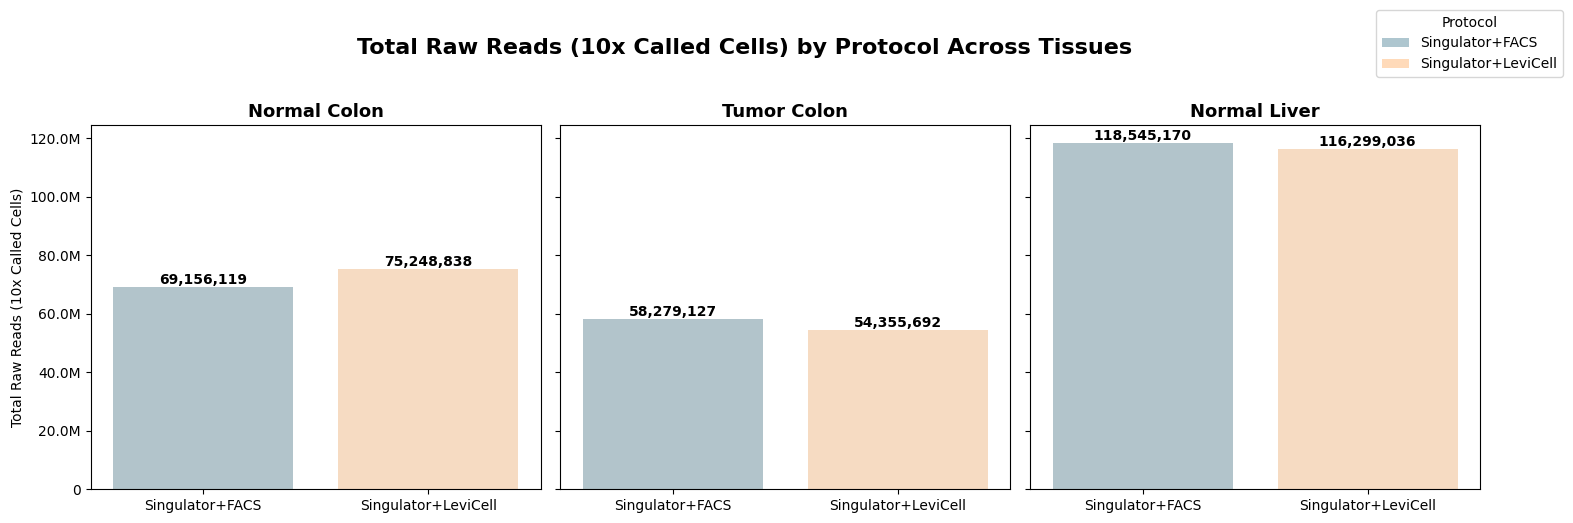

In [14]:
# Plot the total reads per sample for all filtered cells
fig = utils.plot_scalar_metric(
    data_dict=filtered_molecule_info_dict,
    metadata=sample_metadata,
    metric_func=lambda df: df["reads"].sum(),  # Total reads per sample
    metric_label="Total Raw Reads (10x Called Cells)",
    protocol_color_palette=protocol_color_palette,
)

# Save the figure
fig.savefig(
    os.path.join(figures_output_dir, "total_raw_reads_filtered_cells.png"),
    bbox_inches="tight",
)

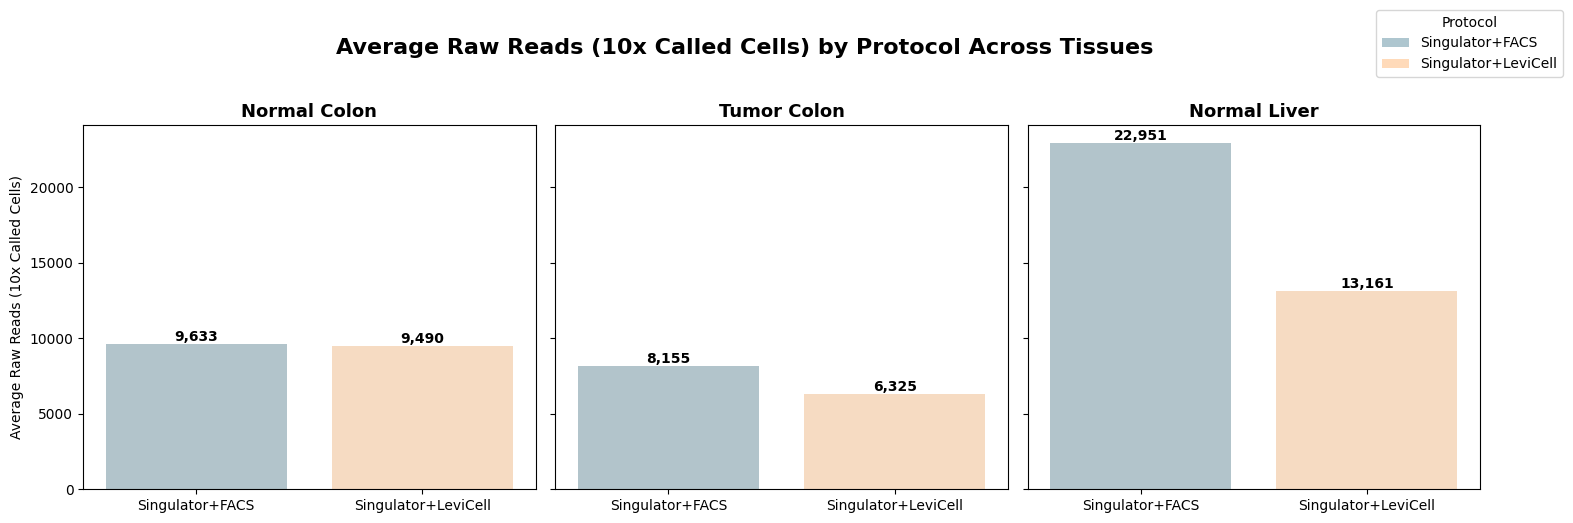

In [15]:
# Plot the total reads per sample for all filtered cells
fig = utils.plot_scalar_metric(
    data_dict=filtered_molecule_info_dict,
    metadata=sample_metadata,
    metric_func=lambda df: df["reads"].sum()
    / df["cell"].n_unique(),  # Total reads per sample divided by number of unique cells
    metric_label="Average Raw Reads (10x Called Cells)",
    protocol_color_palette=protocol_color_palette,
)

# Save the figure
fig.savefig(
    os.path.join(figures_output_dir, "average_raw_reads_per_cell.png"),
    bbox_inches="tight",
)

### Downsampling

#### Functions

- _sample_reads: helper function to subsample counts from a list or array
- perform_downsampling: takes in a molecule info dataframe and performs that actual filtering using the helper function above
- run_downsampling: calls perform_downsampling on all of the molecule_info dfs in the dict
- compute_total_target_reads: programmatically computes total target reads for each AnnData based on the lowest number of total target reads for a tissue multiplied by a scaling factor (default 0.98)

In [22]:
def _sample_reads(x, n):
    """
    Subsample counts.

    Example:
    # data looks like
    x = [1, 2, 3, 1]
    total_counts = 7

    # draw 4 counts
    sample_indices = [0, 1, 0, 1, 1, 0, 1]  # length 7, keep 1s, drop 0s

    # get indices
    count_indices = [0, 1, 1, 2, 2, 2, 3]  # length 7, used for grouping

    # group by indices and sum
    sample_counts = [0, 1, 2, 1]
    """
    assert n < x.sum(), f"n ({n}) must be smaller than total counts ({x.sum()})"
    total_count = x.sum()
    sample_indices = np.random.binomial(1, n / total_count, total_count)
    count_indices = np.repeat(np.arange(len(x)), x)
    sample_counts = np.bincount(count_indices, weights=sample_indices).astype("int32")
    return sample_counts


def perform_downsampling(
    mol_info_df: pl.DataFrame, target_total_reads: int
) -> pl.DataFrame:
    """
    Downsamples a molecule_info DataFrame to a specified total number of reads.

    Args:
        mol_info_df (pl.DataFrame): DataFrame with a 'reads' column.
        target_total_reads (int): Desired total number of reads after downsampling.

    Returns:
        pl.DataFrame: Filtered and downsampled molecule_info DataFrame.
    """
    read_counts = mol_info_df["reads"].to_numpy()
    downsampled_reads = _sample_reads(read_counts, target_total_reads)

    # Keep only molecules with >0 downsampled reads
    nonzero_mask = downsampled_reads > 0
    filtered_df = mol_info_df.filter(pl.Series(nonzero_mask))
    filtered_df = filtered_df.with_columns(
        pl.Series("reads", downsampled_reads[nonzero_mask])
    )

    return filtered_df


def run_downsampling(
    molecule_info_dict: Dict[str, pl.DataFrame], target_total_reads: Dict[str, int]
) -> Dict[str, pl.DataFrame]:
    """
    Runs downsampling on a dictionary of molecule_info DataFrames to a specified total number of reads.

    Args:
        molecule_info_dict (Dict[str, pl.DataFrame]): Dictionary of Polars DataFrames keyed by sample ID.
        target_total_reads (Dict[str, int]): Dictionary of target total reads keyed by sample ID.

    Returns:
        Dict[str, pl.DataFrame]: Downsampled molecule_info DataFrames.
    """
    downsampled_molecule_info_dict = {}

    for key, df in molecule_info_dict.items():
        downsampled_df = perform_downsampling(df, target_total_reads[key])
        downsampled_molecule_info_dict[key] = downsampled_df

    return downsampled_molecule_info_dict

def compute_target_total_reads(
    filtered_molecule_info_dict: Dict[str, pl.DataFrame],
    metadata: Dict[str, Dict[str, str]],
    scaling_factor: float = 0.98
) -> Dict[str, int]:
    """
    Computes target total reads per sample to enable balanced downsampling across protocols within each tissue.

    For each tissue, the function finds the sample with the lowest total read count across all associated protocols,
    multiplies it by a safety factor (default: 0.98), and assigns this target uniformly to all samples of that tissue.

    Args:
        adatfiltered_molecule_info_dictas: Dictionary mapping sample IDs to molecule info dfs.
        metadata: Dictionary mapping sample IDs to metadata dictionaries with a "tissue" key.
        safety_factor: Optional float multiplier applied to the minimum total reads per tissue (default: 0.98).

    Returns:
        Dictionary mapping each sample ID to its computed target total reads (as an integer).
    """

    # Aggregate reads per sample
    total_reads_by_sample = {
        sample_id: molecule_info["reads"].sum() for sample_id, molecule_info in filtered_molecule_info_dict.items()
    }

    # Group samples by tissue
    tissue_to_reads = defaultdict(list)
    for sample_id, meta in metadata.items():
        tissue = meta["tissue"]
        total_reads = total_reads_by_sample[sample_id]
        tissue_to_reads[tissue].append(total_reads)

    # Determine target reads per tissue (minimum across protocols × safety_factor)
    tissue_to_target_reads = {
        tissue: int(min(reads) * scaling_factor)
        for tissue, reads in tissue_to_reads.items()
    }

    # Map back to each sample
    target_total_reads = {
        sample_id: tissue_to_target_reads[metadata[sample_id]["tissue"]]
        for sample_id in filtered_molecule_info_dict
    }

    return target_total_reads

def update_adatas_with_downsampled_umis(
    adata_dict: dict,
    downsampled_molecule_info_dict: dict,
    ensembl_to_symbol: dict,
):
    """
    Updates AnnData objects by adding a `downsampled_umi` layer using gene symbols 
    derived from downsampled molecule information.

    Args:
        adata_dict: Dictionary of AnnData objects keyed by sample ID (can be empty; used to validate sample list).
        downsampled_molecule_infos: Dictionary mapping sample ID to Polars DataFrame of downsampled molecules.
        ensembl_to_symbol: Dictionary mapping Ensembl gene IDs to gene symbols.
    """
    for sample_id in adata_dict.keys():
        adata = adata_dict[sample_id]
        mol_info = downsampled_molecule_info_dict[sample_id]

        # Map Ensembl IDs to gene symbols
        mol_info = mol_info.with_columns([
            pl.col("gene_id").map_elements(
                lambda gid: ensembl_to_symbol.get(gid, gid), return_dtype=pl.Utf8
            ).alias("gene_symbol")
        ])

        # Aggregate UMI counts by (cell, gene_symbol)
        umi_counts_pl = (
            mol_info.group_by(["cell", "gene_symbol"])
            .agg(pl.col("umi").n_unique().alias("umi_count"))
            .pivot(values="umi_count", index="cell", on="gene_symbol")
            .fill_null(0)
        )

        umi_matrix = (
            umi_counts_pl.to_pandas()
            .set_index("cell")
            .rename(index=lambda x: f"{x}-1")  # match Cell Ranger barcodes
        )

        # Align cell barcodes and gene symbols
        cells_to_keep = adata.obs_names.intersection(umi_matrix.index)
        umi_matrix = umi_matrix.loc[cells_to_keep]
        adata = adata[cells_to_keep].copy()

        genes_to_keep = umi_matrix.columns.intersection(adata.var_names)
        umi_matrix = umi_matrix[genes_to_keep]

    
        adata = adata[:, genes_to_keep].copy()

        # Add UMI matrix as new layer
        adata.layers["downsampled_umi"] = sparse.csr_matrix(umi_matrix.values)

        print(f"Updated {sample_id} with downsampled UMIs using gene symbols")



#### Perform Downsampling

In [17]:
# Total reads should be the same across tissues
target_total_reads = compute_target_total_reads(
    filtered_molecule_info_dict=filtered_molecule_info_dict,
    metadata=sample_metadata
)

print(target_total_reads)

downsampled_molecule_info_dict = run_downsampling(
    molecule_info_dict=filtered_molecule_info_dict, target_total_reads=target_total_reads
)

print(downsampled_molecule_info_dict)

{'SF_N': 67772996, 'SL_N': 67772996, 'SF_T': 53268578, 'SL_T': 53268578, 'SF_LN': 113973055, 'SL_LN': 113973055}
{'SF_N': shape: (20_291_640, 5)
┌──────────────────┬──────────┬───────┬─────────────────┬─────────────────┐
│ cell             ┆ umi      ┆ reads ┆ gene_id         ┆ gene_symbol     │
│ ---              ┆ ---      ┆ ---   ┆ ---             ┆ ---             │
│ str              ┆ u32      ┆ i32   ┆ str             ┆ str             │
╞══════════════════╪══════════╪═══════╪═════════════════╪═════════════════╡
│ AAACCCAAGAGAGCGG ┆ 9568298  ┆ 1     ┆ ENSG00000291215 ┆ ENSG00000291215 │
│ AAACCCAAGAGAGCGG ┆ 15478192 ┆ 2     ┆ ENSG00000237491 ┆ LINC01409       │
│ AAACCCAAGAGAGCGG ┆ 16623403 ┆ 13    ┆ ENSG00000228794 ┆ LINC01128       │
│ AAACCCAAGAGAGCGG ┆ 6174631  ┆ 6     ┆ ENSG00000188976 ┆ NOC2L           │
│ AAACCCAAGAGAGCGG ┆ 6478340  ┆ 4     ┆ ENSG00000131591 ┆ C1orf159        │
│ …                ┆ …        ┆ …     ┆ …               ┆ …               │
│ TTTGTTGTCGTAACCA 

### Read in AnnDatas

We'll read in the AnnDatas so that we can add the UMIs from the downsampled molecule infos as a new layer to the AnnDatas and save them to files

In [18]:
# Load AnnData objects
adata_dict = {}

for key, sample_info in sample_metadata.items():
    tissue = sample_info["tissue"]
    protocol = sample_info["protocol"]

    folder = f"{sample_identifier}_{key}"

    file_path = os.path.join(
        input_adata_dir,
        f"{key}_adata.h5ad",
    )

    adata = sc.read_h5ad(file_path)
    adata_dict[key] = adata
    print(f"{key}: {adata}")

SF_N: AnnData object with n_obs × n_vars = 7179 × 38606
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'n_counts'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
SL_N: AnnData object with n_obs × n_vars = 7929 × 38606
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'n_counts'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
SF_T: AnnData object with n_obs × n_vars = 7146 × 38606
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'n_counts'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
SL_T: AnnData

In [23]:
update_adatas_with_downsampled_umis(
    adata_dict=adata_dict,
    downsampled_molecule_info_dict=downsampled_molecule_info_dict,
    ensembl_to_symbol=ensembl_to_symbol,
)

for key, adata in adata_dict.items():
    print(adata)
    # output_file_path = output_adata_dir / f"{key}_adata.h5ad"
    # adata.write(output_file_path)


Updated SF_N with downsampled UMIs using gene symbols
Updated SL_N with downsampled UMIs using gene symbols
Updated SF_T with downsampled UMIs using gene symbols
Updated SL_T with downsampled UMIs using gene symbols
Updated SF_LN with downsampled UMIs using gene symbols
Updated SL_LN with downsampled UMIs using gene symbols
AnnData object with n_obs × n_vars = 7179 × 38606
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'n_counts'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
AnnData object with n_obs × n_vars = 7929 × 38606
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'n_counts'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
AnnData object with n_obs × 

### Gene Discovery Downsampled Curves

#### Computation Functions
- compute_gene_discovery_downsampled_stats: Runs downsampling at different leves and computes summary statistics from these (total reads, mean reads, median UMIS, median genes)

In [ ]:
def compute_gene_discovery_downsampled_stats(
    filtered_molecule_info_dict: Dict[str, pl.DataFrame],
    target_total_reads: Dict[str, int],
    n_steps: int = 10,
    min_reads: int = 10_000_000,
) -> Dict[str, Dict[str, list]]:
    """
    Compute gene discovery statistics (median UMIs, genes per cell, and mean reads per cell) by downsampling.

    Args:
        filtered_molecule_info_dict (Dict[str, pl.DataFrame]): Dict of molecule_info DataFrames keyed by sample ID.
        target_total_reads (Dict[str, int]): Dict of target total reads per sample.
        n_steps (int): Number of evenly spaced read levels to compute between min_reads and max.
        min_reads (int): Minimum number of reads to start downsampling from.

    Returns:
        Dict[str, Dict[str, list]]: Results keyed by sample with read depths and median stats.
    """
    results = {
        sample_id: {
            "total_reads": [],
            "mean_reads": [],
            "median_umis": [],
            "median_genes": [],
        }
        for sample_id in filtered_molecule_info_dict
    }

    for sample_id, mol_info in filtered_molecule_info_dict.items():
        max_reads = target_total_reads[sample_id]
        steps = np.linspace(min_reads, max_reads, n_steps, dtype=int)

        for target in steps:
            # Downsample reads
            downsampled_df = perform_downsampling(mol_info, target)

            # Group by cell once, computing total reads and mean reads
            cell_reads = (
                downsampled_df.group_by("cell")
                .agg(pl.sum("reads").alias("reads"))
            )

            total_reads = cell_reads["reads"].sum()
            mean_reads = cell_reads["reads"].mean()

            # Compute unique UMIs per (cell, gene)
            umi_counts = downsampled_df.group_by(["cell", "gene_id"]).agg(
                pl.col("umi").n_unique().alias("umi_count")
            )

            # Group again by cell for final summaries
            grouped = umi_counts.group_by("cell").agg([
                pl.sum("umi_count").alias("umis"),
                pl.count("gene_id").alias("genes"),
            ])

            median_umis = grouped["umis"].median()
            median_genes = grouped["genes"].median()

            # Append to results
            results[sample_id]["total_reads"].append(float(total_reads))
            results[sample_id]["mean_reads"].append(float(mean_reads))
            results[sample_id]["median_umis"].append(float(median_umis))
            results[sample_id]["median_genes"].append(float(median_genes))

    return results, downsampled_df

### Plotting Functions
- plot_downsampling_curve_by_metric: Plots the downsampling curve, showing UMI/gene capture at different numbers of total reads

In [29]:
def plot_downsampling_curve_by_metric(
    summary_stats: Dict[str, Dict[str, np.ndarray]],
    sample_metadata: Dict[str, tuple],
    protocol_color_palette: Dict[str, str],
    metric_key: str = "median_umis",
    match_x_axis: bool = False,
) -> plt.Figure:
    """
    Plots a downsampling curve for the specified metric across tissues.

    Args:
        summary_stats: Dict mapping sample_id to bootstrapped stats.
        sample_metadata: Dict mapping sample_id to (sample_name, tissue, protocol).
        protocol_color_palette: Mapping from protocol to color.
        metric_key: Either "median_umis" or "median_genes".

    Returns:
        Matplotlib Figure.
    """
    if metric_key not in ["median_umis", "median_genes"]:
        raise ValueError("metric_key must be 'median_umis' or 'median_genes'")

    metric_label = (
        "Median UMIs per Cell"
        if metric_key == "median_umis"
        else "Median Genes per Cell"
    )
    title = f"{metric_label} vs Total Reads"

    tissues = list(dict.fromkeys(tissue for _, tissue, _ in sample_metadata.values()))
    n_tissues = len(tissues)

    # Map tissue to sample_ids
    tissue_to_samples = {tissue: [] for tissue in tissues}
    for sample_id, (_, tissue, _) in sample_metadata.items():
        tissue_to_samples[tissue].append(sample_id)

    # Create subplots
    fig, axes = plt.subplots(1, n_tissues, figsize=(6 * n_tissues, 5), sharey=True)
    if n_tissues == 1:
        axes = [axes]

    if match_x_axis:
        # Match x-axis limits across subplots
        all_x = np.concatenate(
            [
                summary_stats[sample_id]["total_reads_mean"]
                for sample_id in summary_stats
            ]
        )
        xmin, xmax = all_x.min(), all_x.max()

        for ax in axes:
            ax.set_xlim(xmin, xmax)

    for i, tissue in enumerate(tissues):
        ax = axes[i]
        for sample_id in tissue_to_samples[tissue]:
            stats = summary_stats[sample_id]
            _, _, protocol = sample_metadata[sample_id]
            color = protocol_color_palette.get(protocol, "gray")

            ax.errorbar(
                stats["total_reads_mean"],
                stats[f"{metric_key}_mean"],
                yerr=stats[f"{metric_key}_std"],
                label=protocol,
                marker="o",
                capsize=3,
                color=color,
            )

        ax.set_title(tissue, fontsize=13, weight="bold")
        ax.set_xlabel("Total Reads")
        ax.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(utils.adaptive_formatter))
        if i == 0:
            ax.set_ylabel(metric_label)

    fig.suptitle(f"{title}", fontsize=16, weight="bold")
    fig.legend(
        handles=[
            mpl.patches.Patch(color=c, label=p)
            for p, c in protocol_color_palette.items()
        ],
        title="Protocol",
        loc="upper right",
        bbox_to_anchor=(1.05, 1),
    )
    fig.tight_layout(rect=[0, 0, 1, 0.95])
    return fig

### Calculate Summary Stats

Warning: cell below takes a very long time to complete - best to use a separate script with multiprocessing to parallelize operations:

In [ ]:
from collections import defaultdict
import numpy as np

n_bootstraps = 1
n_steps = 10
min_reads = 10_000_000

# Run 10 bootstraps and store each replicate
bootstrap_results = defaultdict(lambda: defaultdict(list))
downsampled_df_dict = defaultdict(list)

for i in range(n_bootstraps):
    bootstrap_result, downsampled_df = compute_gene_discovery_downsampled_stats(
        filtered_molecule_info_dict=filtered_molecule_info_dict,
        target_total_reads=target_total_reads,
        n_steps=n_steps,
        min_reads=min_reads,
    )
    
    for sample_id in bootstrap_result:
        downsampled_df_dict[sample_id].append(downsampled_df)
        for key in ["total_reads", "mean_reads", "median_umis", "median_genes"]:
            bootstrap_results[sample_id][key].append(
                bootstrap_result[sample_id][key]
            )
    
# Summarize into plot-ready format
summary_stats = defaultdict(dict)
for sample_id, stats in bootstrap_results.items():
    # Each key is a list of n_bootstraps × n_steps
    total_reads_array = np.array(stats["total_reads"])  # shape: (n_bootstraps, n_steps)
    mean_reads_array = np.array(stats["mean_reads"])  # shape: (n_bootstraps, n_steps)
    median_umis_array = np.array(stats["median_umis"])
    median_genes_array = np.array(stats["median_genes"])

    # Mean and std across bootstraps
    summary_stats[sample_id]["total_reads_mean"] = total_reads_array.mean(axis=0)
    summary_stats[sample_id]["total_reads_std"] = total_reads_array.std(axis=0)

    summary_stats[sample_id]["mean_reads_mean"] = mean_reads_array.mean(axis=0)
    summary_stats[sample_id]["mean_reads_std"] = mean_reads_array.std(axis=0)

    summary_stats[sample_id]["median_umis_mean"] = median_umis_array.mean(axis=0)
    summary_stats[sample_id]["median_umis_std"] = median_umis_array.std(axis=0)

    summary_stats[sample_id]["median_genes_mean"] = median_genes_array.mean(axis=0)
    summary_stats[sample_id]["median_genes_std"] = median_genes_array.std(axis=0)


Save info if desired

In [ ]:
import dill

with open(os.path.join(DATA_DIR, "other", "one_bootstrap", "downsampling_molecule_infos.dill"), "wb") as f:
    dill.dump(downsampled_df_dict, f)

with open(os.path.join(DATA_DIR, "other", "one_bootstrap", "downsampling_bootstrap_results.dill"), "wb") as f:
    dill.dump(bootstrap_results, f)

with open(os.path.join(DATA_DIR, "other", "one_bootstrap", "downsampling_summary_stats.dill"), "wb") as f:
    dill.dump(summary_stats, f)



### Plot Curves

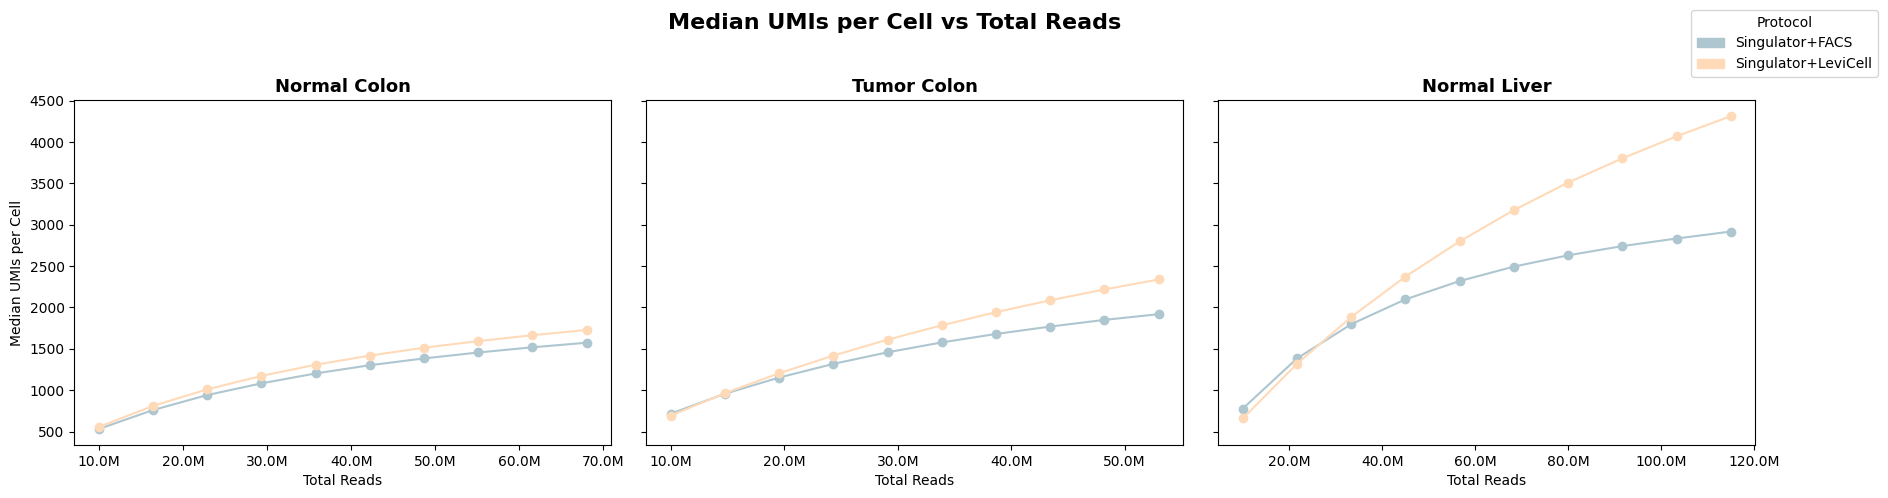

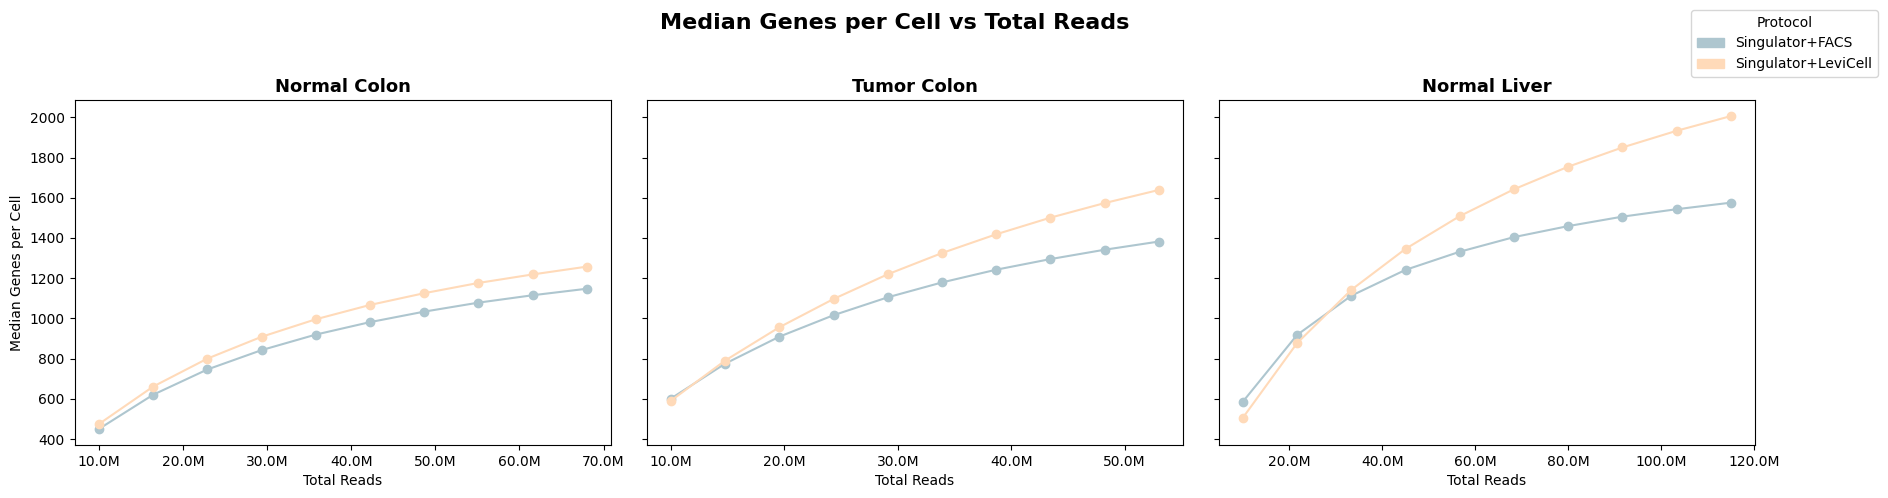

In [ ]:
fig_umis = plot_downsampling_curve_by_metric(
    summary_stats,
    samples,
    protocol_color_palette,
    metric_key="median_umis",
    match_x_axis=False,
)
fig_genes = plot_downsampling_curve_by_metric(
    summary_stats,
    samples,
    protocol_color_palette,
    metric_key="median_genes",
    match_x_axis=False,
)

# Save the figures
fig_umis.savefig(
    os.path.join(FIGURES_OUTPUT_DIR, "downsampling_curve_median_umis.png"),
    bbox_inches="tight",
)
fig_genes.savefig(
    os.path.join(FIGURES_OUTPUT_DIR, "downsampling_curve_median_genes.png"),
    bbox_inches="tight",
)